# ***Airspeed Message analysis to detect outliers based on DBSCAN***
This notebook is used to perform additional analytics for the Airspeed message. DBSCAN clustering is applied to detect outliers from the message.

In [2]:
#Install the pip packages.
!pip install facets-overview
!pip install bigdl
!pip install pandas
!pip install matplotlib

In [3]:
import pandas as pd
import base64
from facets_overview.generic_feature_statistics_generator import GenericFeatureStatisticsGenerator
from IPython.core.display import display, HTML
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bigdl.chronos.detector.anomaly import DBScanDetector
%matplotlib inline

/tmp/ipykernel_123/118228882.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


### Load data

In [4]:
# Load airspeed data into dataframe.
df_airspeed_data = pd.read_csv("dataset/125068fc-f69b-4160-8f70-15ce5cbfdb80/125068fc-f69b-4160-8f70-15ce5cbfdb80_airspeed_0.csv")

#### Below are records of the data

In [5]:
df_airspeed_data.head()

,timestamp,indicated_airspeed_m_s,true_airspeed_m_s,air_temperature_celsius,confidence
0,579923717,1.138767,1.173579,31.582804,1.0
1,579934448,0.750847,0.773800,31.582804,1.0
2,579945176,-0.552709,-0.569608,31.582804,1.0
3,579955904,-1.091924,-1.125310,31.582804,1.0
4,579966633,-1.420957,-1.464403,31.582804,1.0


### Understand data

In [6]:
gfsg = GenericFeatureStatisticsGenerator()
proto = gfsg.ProtoFromDataFrames([{'name': 'airspeed', 'table': df_airspeed_data}                                  ])
protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")

In [7]:
HTML_TEMPLATE = """
        <script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html" >
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

### Preprocessing

In [8]:
def format_timestamp(df_data):
    return pd.to_datetime(df_data["timestamp"], unit='us').dt.strftime("%H:%M:%S")

df_airspeed_data['displayTime'] = format_timestamp(df_airspeed_data)
df_airspeed_data.sort_values(by="timestamp", inplace=True)
df_airspeed_data.reset_index(inplace=True)

### Plot

<AxesSubplot:title={'center':'Airspeed'}, xlabel='displayTime'>

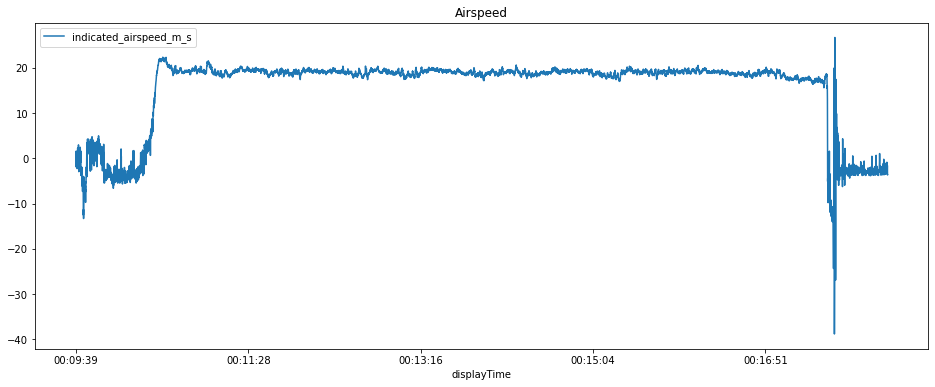

In [9]:
df_airspeed_data.plot(y="indicated_airspeed_m_s", x="displayTime", figsize=(16,6),title="Airspeed")

### Clustering based on DBScan

In [10]:
# DBSCAN instance
ad = DBScanDetector(eps=0.1, min_samples=6)
# fit the values
ad.fit(df_airspeed_data['indicated_airspeed_m_s'].to_numpy())

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### Identified Outliers

In [11]:
anomaly_scores = ad.score()
anomaly_indexes = ad.anomaly_indexes()

print("The anomaly scores idenitied from DBSCAN are:", anomaly_scores)
print("The anomaly indexes are:", anomaly_indexes)

The anomaly scores idenitied from DBSCAN are: [0. 0. 0. ... 0. 0. 0.]
The anomaly indexes are: [  465   530  4408  4471  4493  4498  4499  4550  4551  4554  4555  4568
  4569  4594  4596  4604 43590 43593 43596 43648 43747 43863 43864 43865
 43873 43874 43875 43876 43877 43878 43879 43885 43924 43925 43926 43927
 43937 43938 43939 43940 43941 43942 43943 43944 43945 43946 43947 43948
 43949 43950 43951 43952 43953 43954 43955 43962 43963 43965 43993 43994
 43995 43996 43997 43998 43999 44000 44001 44002 44003 44004 44005 44006
 44007 44008 44009 44010 44011 44012 44013 44014 44015 44021 44022 44023
 44024 44025 44026 44027 44033 44034 44035 44036 44047 44060 44061 44062
 44063 44064 44065 44066 44067 44068 44069 44070 44071 44072 44073 44075
 44079 44118 44123]


### Plot with Outliers

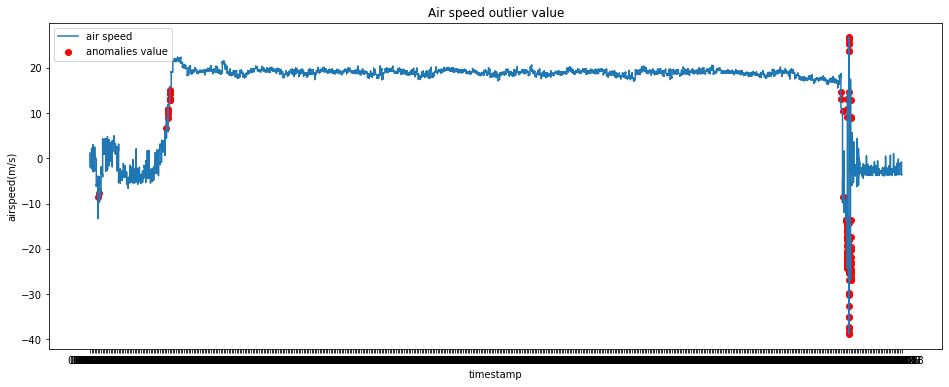

In [12]:
plt.figure(figsize=(16,6))
plt.plot(df_airspeed_data.displayTime, df_airspeed_data.indicated_airspeed_m_s,label='air speed')
plt.scatter(df_airspeed_data.displayTime[anomaly_indexes], df_airspeed_data.indicated_airspeed_m_s[anomaly_indexes], color='red', label='anomalies value')

plt.title('Air speed outlier value')
plt.ylabel('airspeed(m/s)')
plt.xlabel('timestamp')
plt.legend(loc='upper left')
plt.show()